# 3 Pre-processing & Training: Breast Cancer Gene Expressions <a id='3_modeling'></a>

## 3.1 Contents <a id='3.1_contents'></a>

* [3 Preprocessing & Modeling](#3_modeling)
    * [3.1 Contents](#2.1_contents)
    * [3.2 Introduction](#3.2_intro)
    * [3.3 Imports](#3.3_imports)
    * [3.4 Loading the Data](#3.4_loading)
    * [3.5 PCA](#3.5_pca)
    * [3.6 Initial model: Logistic Regression](#3.6_initial_model)
    
        * [3.6.1 Logistic Regression](#3.6.1_lr)
        * [3.6.2 Performance Metrics](#3.6.2_metrics)
    * [3.7 Exporting](#3.7_export)
    * [3.7 Summary & Next Steps](#3.7_summary)

## 3.2 Introduction <a id='3.2_intro'></a>

Up until this point, I have cleaned, wrangled, and done ETA on my dataset of breast cancer gene expressions. In this notebook I will do pre-processing and initial model development. As a part of the pre-processing, I will do PCA in two ways: 1) for 190 components, which means that there will be more than 10 times as many rows as columns, to avoid issues related to being 'wide and short', and 2) for ~360 components, which covers 90% of the variance in the data. I will then do a preliminatry logistic regression model to use as a baseline, and run this model on the data with 190 components, with ~360 components, and with the full dataset. 

## 3.3 Imports  <a id='3.3_imports'></a>

In [1]:
import pyarrow.parquet as pq

%matplotlib inline
#
# data manipulation and math
#
import numpy as np
import scipy as sp
import pandas as pd
#
# plotting and visualization
#
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#
import seaborn as sns
#
# modeling
#
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
#

import pickle

print("Loaded Libraries")

Loaded Libraries


## Set Options

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
#
plt.rcParams['figure.figsize'] = (3, 3)
plt.style.use('seaborn-pastel')
plt.rcParams['figure.dpi'] = 150      
#
c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]
c2 = sns.color_palette()[2]
#
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])


In [3]:
def points_plot(ax, Xtr, Xte, ytr, yte, 
                clf, 
                mesh = True, colorscale = cmap_light, cdiscrete = cmap_bold, 
                alpha = 0.1, psize = 10, 
                zfunc = False, predicted = False):
#
# note: this function only works for X.shape = (:, 2)
# it is intended to illustrate the classifier boundary
#
# get the column names if they exist to apply
# to the meshed data generated below
#
    try:
        feature_names = Xtr.columns
    except:
        feature_names = None
#        
    Xtrain = np.array(Xtr)
    Xtest = np.array(Xte)
#
    h = 0.02
#
# create a uniform grid spanning the range of the X values
# note that y here is NOT the target, it is the 2nd
# dimension of the desired plot
#
    X = np.concatenate((Xtrain, Xtest))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
#
# predict the target value at each point in the grid
#
# this method uses the probabilities from the classifier
# and applies a function to determine the class
#
    if zfunc:
        mesh_data = np.c_[xx.ravel(), yy.ravel()]
        if feature_names is not None:
            mesh_data = pd.DataFrame(mesh_data, 
                         columns = feature_names)
        p0 = clf.predict_proba(mesh_data)[:, 0]
        p1 = clf.predict_proba(mesh_data)[:, 1]
        Z = zfunc(p0, p1)
#
# this method uses the classifier to predict the classes directly
#
    else:
        mesh_data = np.c_[xx.ravel(), yy.ravel()]
        if feature_names is not None:
            mesh_data = pd.DataFrame(mesh_data, 
                                     columns = feature_names)
        Z = clf.predict(mesh_data)
    ZZ = Z.reshape(xx.shape)
#
# plt.pcolormesh() creates a shaded result over the grid
#
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, 
                       cmap = cmap_light, 
                       alpha = alpha, 
                       axes = ax, 
                       shading = 'auto')
#
# add the points to the plot
# these can be the original target values
# or the predicted values
#
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
#
# plot training points
#
    ax.scatter(Xtrain[:, 0], Xtrain[:, 1], 
               c = showtr - 1, 
               cmap = cmap_bold, 
               s = psize, 
               alpha = alpha, 
               edgecolor = "k")
#    
# plot testing points
#
    ax.scatter(Xtest[:, 0], Xtest[:, 1],
               c = showte - 1, 
               cmap = cmap_bold, 
               s = psize + 10,
               alpha = alpha, 
               marker = "s")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
#
    return ax, xx, yy

## 3.4 Loading the Data <a id='3.4_loading'></a>

In [4]:
# importing using parquet to preserve data types

num_data=pd.read_parquet(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\num_data.parquet', engine='pyarrow')

In [5]:
num_data.head()

,age_at_diagnosis,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,tumor_size,type_of_breast_surgery_BREAST CONSERVING,type_of_breast_surgery_MASTECTOMY,type_of_breast_surgery_nan,cancer_type_Breast Cancer,cancer_type_Breast Sarcoma,cancer_type_detailed_Breast,cancer_type_detailed_Breast Invasive Ductal Carcinoma,cancer_type_detailed_Breast Invasive Lobular Carcinoma,cancer_type_detailed_Breast Invasive Mixed Mucinous Carcinoma,cancer_type_detailed_Breast Mixed Ductal and Lobular Carcinoma,cancer_type_detailed_Metaplastic Breast Cancer,cancer_type_detailed_nan,cellularity_High,cellularity_Low,cellularity_Moderate,cellularity_nan,chemotherapy_0,chemotherapy_1,pam50_+_claudin-low_subtype_Basal,pam50_+_claudin-low_subtype_Her2,pam50_+_claudin-low_subtype_LumA,pam50_+_claudin-low_subtype_LumB,pam50_+_claudin-low_subtype_NC,pam50_+_claudin-low_subtype_Normal,pam50_+_claudin-low_subtype_claudin-low,cohort_1,cohort_2,cohort_3,cohort_4,cohort_5,er_status_measured_by_ihc_Negative,er_status_measured_by_ihc_Positive,er_status_measured_by_ihc_nan,er_status_Negative,er_status_Positive,neoplasm_histologic_grade_1.0,neoplasm_histologic_grade_2.0,neoplasm_histologic_grade_3.0,neoplasm_histologic_grade_nan,her2_status_measured_by_snp6_GAIN,her2_status_measured_by_snp6_LOSS,her2_status_measured_by_snp6_NEUTRAL,her2_status_measured_by_snp6_UNDEF,her2_status_Negative,her2_status_Positive,tumor_other_histologic_subtype_Ductal/NST,tumor_other_histologic_subtype_Lobular,tumor_other_histologic_subtype_Medullary,tumor_other_histologic_subtype_Metaplastic,tumor_other_histologic_subtype_Mixed,tumor_other_histologic_subtype_Mucinous,tumor_other_histologic_subtype_Other,tumor_other_histologic_subtype_Tubular/ cribriform,tumor_other_histologic_subtype_nan,hormone_therapy_0,hormone_therapy_1,inferred_menopausal_state_Post,inferred_menopausal_state_Pre,primary_tumor_laterality_Left,primary_tumor_laterality_Right,primary_tumor_laterality_nan,oncotree_code_BREAST,oncotree_code_IDC,oncotree_code_ILC,oncotree_code_IMMC,oncotree_code_MBC,oncotree_code_MDLC,oncotree_code_nan,overall_survival_0,overall_survival_1,pr_status_Negative,pr_status_Positive,radio_therapy_0,radio_therapy_1,3-gene_classifier_subtype_ER+/HER2- High Prolif,3-gene_classifier_subtype_ER+/HER2- Low Prolif,3-gene_classifier_subtype_ER-/HER2-,3-gene_classifier_subtype_HER2+,3-gene_classifier_subtype_nan,tumor_stage_0.0,tumor_stage_1.0,tumor_stage_2.0,tumor_stage_3.0,tumor_stage_4.0,tumor_stage_nan,death_from_cancer_0,death_from_cancer_1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,rad50,rb1,rbl1,rbl2,ccna1,ccnb1,cdk1,ccne1,cdk2,cdc25a,ccnd1,cdk4,cdk6,ccnd2,cdkn2a,cdkn2b,myc,cdkn1a,cdkn1b,e2f1,e2f2,e2f3,e2f4,e2f5,e2f6,e2f7,e2f8,src,jak1,jak2,stat1,stat2,stat3,stat5a,stat5b,mdm2,tp53bp1,adam10,adam17,aph1a,aph1b,arrdc1,cir1,ctbp1,ctbp2,cul1,dll1,dll3,dll4,dtx1,dtx2,dtx3,dtx4,ep300,fbxw7,hdac1,hdac2,hes1,hes5,heyl,itch,jag1,jag2,kdm5a,lfng,maml1,maml2,maml3,ncor2,ncstn,notch1,notch2,notch3,nrarp,numb,numbl,psen1,psen2,psenen,rbpj,rbpjl,rfng,snw1,spen,hes2,hes4,hes7,hey1,hey2,acvr1,acvr1b,acvr1c,acvr2a,acvr2b,acvrl1,akt1,akt1s1,akt2,apaf1,arl11,atr,aurka,bad,bcl2,bcl2l1,bmp10,bmp15,bmp2,bmp3,bmp4,bmp5,bmp6,bmp7,bmpr1a,bmpr1b,bmpr2,braf,casp10,casp3,casp6,casp7,casp8,casp9,chek1,csf1,csf1r,cxcl8,cxcr1,cxcr2,dab2,diras3,dlec1,dph1,egfr,eif4e,eif4ebp1,eif5a2,erbb2,erbb3,erbb4,fas,fgf1,fgfr1,folr1,folr2,folr3,foxo1,foxo3,gdf11,gdf2,gsk3b,hif1a,hla-g,hras,igf1,igf1r,inha,inhba,inhbc,itgav,itgb3,izumo1r,kdr,kit,kras,map2k1,map2k2,map2k3,map2k4,map2k5,map3k1,map3k3,map3k4,map3k5,mapk1,mapk12,mapk14,mapk3,mapk4,mapk6,mapk7,mapk8,mapk9,mdc1,mlst8,mmp1,mmp10,mmp11,mmp12,mmp13,mmp14,mmp15,mmp16,mmp17,mmp19,mmp2,mmp21,mmp23b,mmp24,mmp25,mmp26,mmp27,mmp28,mmp3,mmp7,mmp9,mtor,nfkb1,nfkb2,opcml,pdgfa,pdgfb,pdgfra,pdgfrb,pdpk1,peg3,pik3ca,pik3r1,pik3r2,plagl1,ptk2,rab25,rad51,raf1,rassf1,rheb,rictor,rps6,rps6ka1,rps6ka

In [6]:
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1903 entries, 0 to 7299
Columns: 754 entries, age_at_diagnosis to siah1_mut
dtypes: float64(492), int64(262)
memory usage: 11.0 MB


In [7]:
# checking data types
num_data.dtypes

age_at_diagnosis                 float64
lymph_nodes_examined_positive      int64
mutation_count                     int64
nottingham_prognostic_index      float64
overall_survival_months          float64
                                  ...   
hras_mut                           int64
prps2_mut                          int64
smarcb1_mut                        int64
stmn2_mut                          int64
siah1_mut                          int64
Length: 754, dtype: object

In [8]:
# confirming no missing data
num_data.isnull().values.any()

False

## 3.5 PCA <a id='3.5_pca'></a>

### How many features do I need to keep to avoid wide & short?

In [9]:
# to figure out how much of my data to keep, I ideally want 10 times as many rows as features so that it's not wide and short.
rows = num_data.shape[0]
ideal_features = rows/10
print('Ideal number of features:',ideal_features)

Ideal number of features: 190.3


I will aim to have 190 features or less, if possible. I will keep this in mind during the next step. 

### Prepare data for PCA

In [10]:
# I need to drop the extra death_from_cancer_1 column, and rename death_from_cancer_0 to just outcome
#MAKING A CHANGE : 0 = Survived or died of other causes, 1 = Died of Disease

num_data = num_data.rename(columns={"death_from_cancer_0":"outcome"})
num_data = num_data.drop("death_from_cancer_1",axis=1)

In [11]:
#move outcomes to the first column
first_column= num_data.pop('outcome')
num_data.insert(0, 'outcome', first_column)

In [12]:
# drop overall_survival_0, overall_survival_1, and overall_survival_months so that we don't have data leakage.

num_data = num_data.drop(['overall_survival_0','overall_survival_1','overall_survival_months'],axis=1)

In [13]:
num_data.head()

,outcome,age_at_diagnosis,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,tumor_size,type_of_breast_surgery_BREAST CONSERVING,type_of_breast_surgery_MASTECTOMY,type_of_breast_surgery_nan,cancer_type_Breast Cancer,cancer_type_Breast Sarcoma,cancer_type_detailed_Breast,cancer_type_detailed_Breast Invasive Ductal Carcinoma,cancer_type_detailed_Breast Invasive Lobular Carcinoma,cancer_type_detailed_Breast Invasive Mixed Mucinous Carcinoma,cancer_type_detailed_Breast Mixed Ductal and Lobular Carcinoma,cancer_type_detailed_Metaplastic Breast Cancer,cancer_type_detailed_nan,cellularity_High,cellularity_Low,cellularity_Moderate,cellularity_nan,chemotherapy_0,chemotherapy_1,pam50_+_claudin-low_subtype_Basal,pam50_+_claudin-low_subtype_Her2,pam50_+_claudin-low_subtype_LumA,pam50_+_claudin-low_subtype_LumB,pam50_+_claudin-low_subtype_NC,pam50_+_claudin-low_subtype_Normal,pam50_+_claudin-low_subtype_claudin-low,cohort_1,cohort_2,cohort_3,cohort_4,cohort_5,er_status_measured_by_ihc_Negative,er_status_measured_by_ihc_Positive,er_status_measured_by_ihc_nan,er_status_Negative,er_status_Positive,neoplasm_histologic_grade_1.0,neoplasm_histologic_grade_2.0,neoplasm_histologic_grade_3.0,neoplasm_histologic_grade_nan,her2_status_measured_by_snp6_GAIN,her2_status_measured_by_snp6_LOSS,her2_status_measured_by_snp6_NEUTRAL,her2_status_measured_by_snp6_UNDEF,her2_status_Negative,her2_status_Positive,tumor_other_histologic_subtype_Ductal/NST,tumor_other_histologic_subtype_Lobular,tumor_other_histologic_subtype_Medullary,tumor_other_histologic_subtype_Metaplastic,tumor_other_histologic_subtype_Mixed,tumor_other_histologic_subtype_Mucinous,tumor_other_histologic_subtype_Other,tumor_other_histologic_subtype_Tubular/ cribriform,tumor_other_histologic_subtype_nan,hormone_therapy_0,hormone_therapy_1,inferred_menopausal_state_Post,inferred_menopausal_state_Pre,primary_tumor_laterality_Left,primary_tumor_laterality_Right,primary_tumor_laterality_nan,oncotree_code_BREAST,oncotree_code_IDC,oncotree_code_ILC,oncotree_code_IMMC,oncotree_code_MBC,oncotree_code_MDLC,oncotree_code_nan,pr_status_Negative,pr_status_Positive,radio_therapy_0,radio_therapy_1,3-gene_classifier_subtype_ER+/HER2- High Prolif,3-gene_classifier_subtype_ER+/HER2- Low Prolif,3-gene_classifier_subtype_ER-/HER2-,3-gene_classifier_subtype_HER2+,3-gene_classifier_subtype_nan,tumor_stage_0.0,tumor_stage_1.0,tumor_stage_2.0,tumor_stage_3.0,tumor_stage_4.0,tumor_stage_nan,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,rad50,rb1,rbl1,rbl2,ccna1,ccnb1,cdk1,ccne1,cdk2,cdc25a,ccnd1,cdk4,cdk6,ccnd2,cdkn2a,cdkn2b,myc,cdkn1a,cdkn1b,e2f1,e2f2,e2f3,e2f4,e2f5,e2f6,e2f7,e2f8,src,jak1,jak2,stat1,stat2,stat3,stat5a,stat5b,mdm2,tp53bp1,adam10,adam17,aph1a,aph1b,arrdc1,cir1,ctbp1,ctbp2,cul1,dll1,dll3,dll4,dtx1,dtx2,dtx3,dtx4,ep300,fbxw7,hdac1,hdac2,hes1,hes5,heyl,itch,jag1,jag2,kdm5a,lfng,maml1,maml2,maml3,ncor2,ncstn,notch1,notch2,notch3,nrarp,numb,numbl,psen1,psen2,psenen,rbpj,rbpjl,rfng,snw1,spen,hes2,hes4,hes7,hey1,hey2,acvr1,acvr1b,acvr1c,acvr2a,acvr2b,acvrl1,akt1,akt1s1,akt2,apaf1,arl11,atr,aurka,bad,bcl2,bcl2l1,bmp10,bmp15,bmp2,bmp3,bmp4,bmp5,bmp6,bmp7,bmpr1a,bmpr1b,bmpr2,braf,casp10,casp3,casp6,casp7,casp8,casp9,chek1,csf1,csf1r,cxcl8,cxcr1,cxcr2,dab2,diras3,dlec1,dph1,egfr,eif4e,eif4ebp1,eif5a2,erbb2,erbb3,erbb4,fas,fgf1,fgfr1,folr1,folr2,folr3,foxo1,foxo3,gdf11,gdf2,gsk3b,hif1a,hla-g,hras,igf1,igf1r,inha,inhba,inhbc,itgav,itgb3,izumo1r,kdr,kit,kras,map2k1,map2k2,map2k3,map2k4,map2k5,map3k1,map3k3,map3k4,map3k5,mapk1,mapk12,mapk14,mapk3,mapk4,mapk6,mapk7,mapk8,mapk9,mdc1,mlst8,mmp1,mmp10,mmp11,mmp12,mmp13,mmp14,mmp15,mmp16,mmp17,mmp19,mmp2,mmp21,mmp23b,mmp24,mmp25,mmp26,mmp27,mmp28,mmp3,mmp7,mmp9,mtor,nfkb1,nfkb2,opcml,pdgfa,pdgfb,pdgfra,pdgfrb,pdpk1,peg3,pik3ca,pik3r1,pik3r2,plagl1,ptk2,rab25,rad51,raf1,rassf1,rheb,rictor,rps6,rps6ka1,rps6ka2,rps6kb1,rps6kb2,rptor,slc19a1,smad1,smad2,smad3,smad4,smad5,smad6,smad7,smad9,sptbn1,terc,te

### Train/test split and scaling

In [14]:
# first separate out my 'outcome' column
X = num_data.drop('outcome', axis=1)
y = num_data['outcome']

In [15]:
# perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [16]:
#scale the data - don't do fit on test data so that we don't influence it with training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
#verify the scaling:

# call the mean 
print('train data mean: ',np.mean(X_train))

# call the standard deviation:
print('train data standard deviation: ',np.std(X_train))

train data mean:  -9.938609011607627e-19
train data standard deviation:  0.9986639940594172


### Apply PCA

First, let's do it for 190 components, which means that we are following the rule of thumb of 10x as many rows as features. 

In [18]:
# fit the training data
pca190 = PCA(n_components=190)
train_data_pca190 = pca190.fit(X_train)

Now let's do another PCA where we want it to account for 90% of the variance.

In [19]:
pca360 = PCA(n_components=0.90)
train_data_pca360 = pca360.fit(X_train)

In [20]:
print("Number of components when n_components set to 0.90: ", pca360.n_components_)

Number of components when n_components set to 0.90:  354


NOTE: Every time I run this, I get a slightly different number of components here. It was originally 360, so I'm using that as the variable name for consistency. 

And let's do it for 25 components, which is what we get with the 'elbow method'

In [21]:
pca25=PCA(n_components=25)
train_data_pca25 = pca25.fit(X_train)

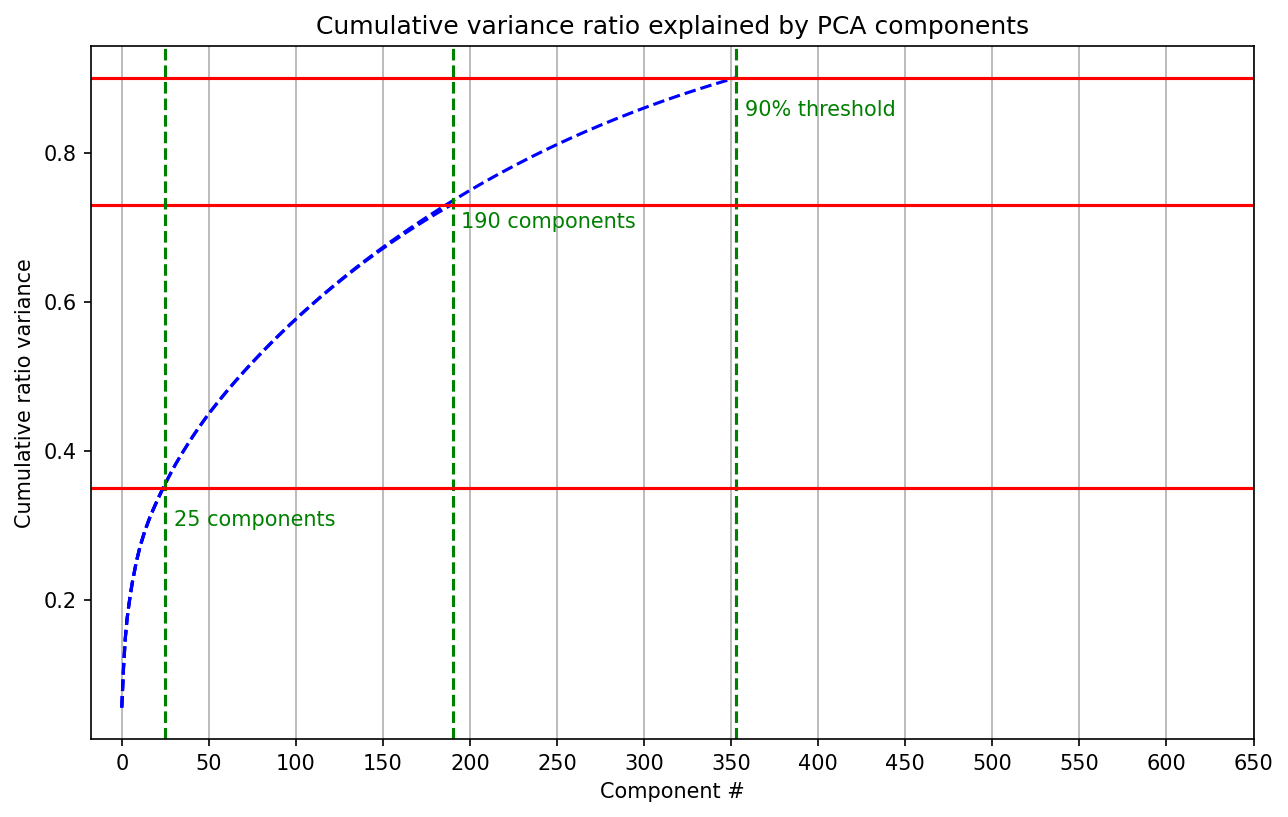

In [22]:
# plot the cumulative variance ratio explained by pca components. 

plt.subplots(figsize=(10, 6))
plt.plot(train_data_pca190.explained_variance_ratio_.cumsum(), linestyle='--', color='b')
plt.plot(train_data_pca360.explained_variance_ratio_.cumsum(), linestyle='--', color='b')
plt.plot(train_data_pca25.explained_variance_ratio_.cumsum(), linestyle='--', color='b')
plt.xlabel('Component #')
plt.xticks(np.arange(0, 700, step=50))
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components')

plt.axhline(y=0.90, color='r', linestyle='-')
plt.axvline(x=np.argmax(train_data_pca360.explained_variance_ratio_.cumsum() >= 0.90), color='g', linestyle='--')
plt.text(np.argmax(train_data_pca360.explained_variance_ratio_.cumsum() >= 0.9) + 5, 0.85, '90% threshold', color='green')

# Add threshold line for 190 components
plt.axvline(x=190, color='g', linestyle='--')
plt.text(190 + 5, 0.7, '190 components', color='g')

plt.axhline(y=0.73, color='r', linestyle='-')

# Add threshold line for 25 components
plt.axvline(x=25, color='g', linestyle='--')
plt.text(25 + 5, 0.3, '25 components', color='g')
plt.axhline(y=0.35, color='r', linestyle='-')

#plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.grid(axis='x')
plt.show;

In [23]:
# how much variance is explained by using 25 components
explained_variance_ratio_25 = pca25.explained_variance_ratio_

total_variance_accounted = sum(explained_variance_ratio_25)

print("Total variance accounted for by the 25 components:", total_variance_accounted)

Total variance accounted for by the 25 components: 0.3511767892138006


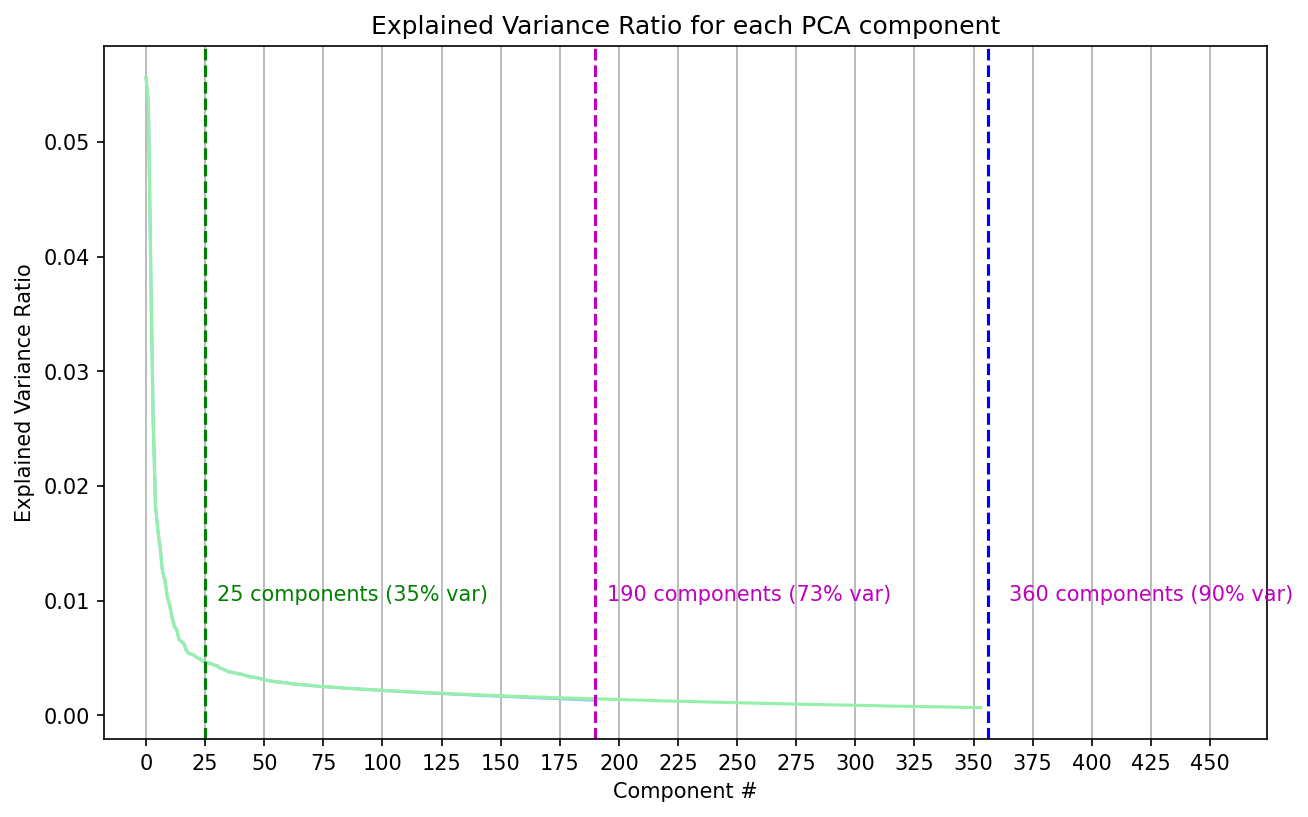

In [24]:
plt.subplots(figsize=(10, 6))
plt.plot(train_data_pca190.explained_variance_ratio_)
plt.plot(train_data_pca360.explained_variance_ratio_)
plt.xlabel('Component #')
plt.grid(axis='x')
plt.xticks(np.arange(0, 474, step=25))
plt.xlim(right=474)
# Add threshold line for 190 components (73% variance)
plt.axvline(x=190, color='m', linestyle='--')
plt.text(190+5, 0.01, '190 components (73% var)', color='m')
# Add threshold line for 360 components (90% variance)
plt.axvline(x=356, color='b', linestyle='--')
plt.text(360+5, 0.01, '360 components (90% var)', color='m')

# Add threshold line for 25 components 
plt.axvline(x=25, color='g', linestyle='--')
plt.text(25+5, 0.01, '25 components (35% var)', color='g')


plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for each PCA component')
plt.show()

<b>Summary so far</b>: 360 components has an explained variance ratio of 90%, and 190 components (which makes my data set good proportions) has an expalined variance ratio of 73% As you can see above, Each component accounts for a very small amount of variance in the data. 

### Transform the data

In [25]:
# 25 components
train_pca25_trans = pca25.transform(X_train)
test_pca25_trans= pca25.transform(X_test)

# 190 components
train_pca190_trans = pca190.transform(X_train)
test_pca190_trans = pca190.transform(X_test)

# 360 components
train_pca360_trans = pca360.transform(X_train)
test_pca360_trans = pca360.transform(X_test)

Let's look at a plot of the first 2 components: 

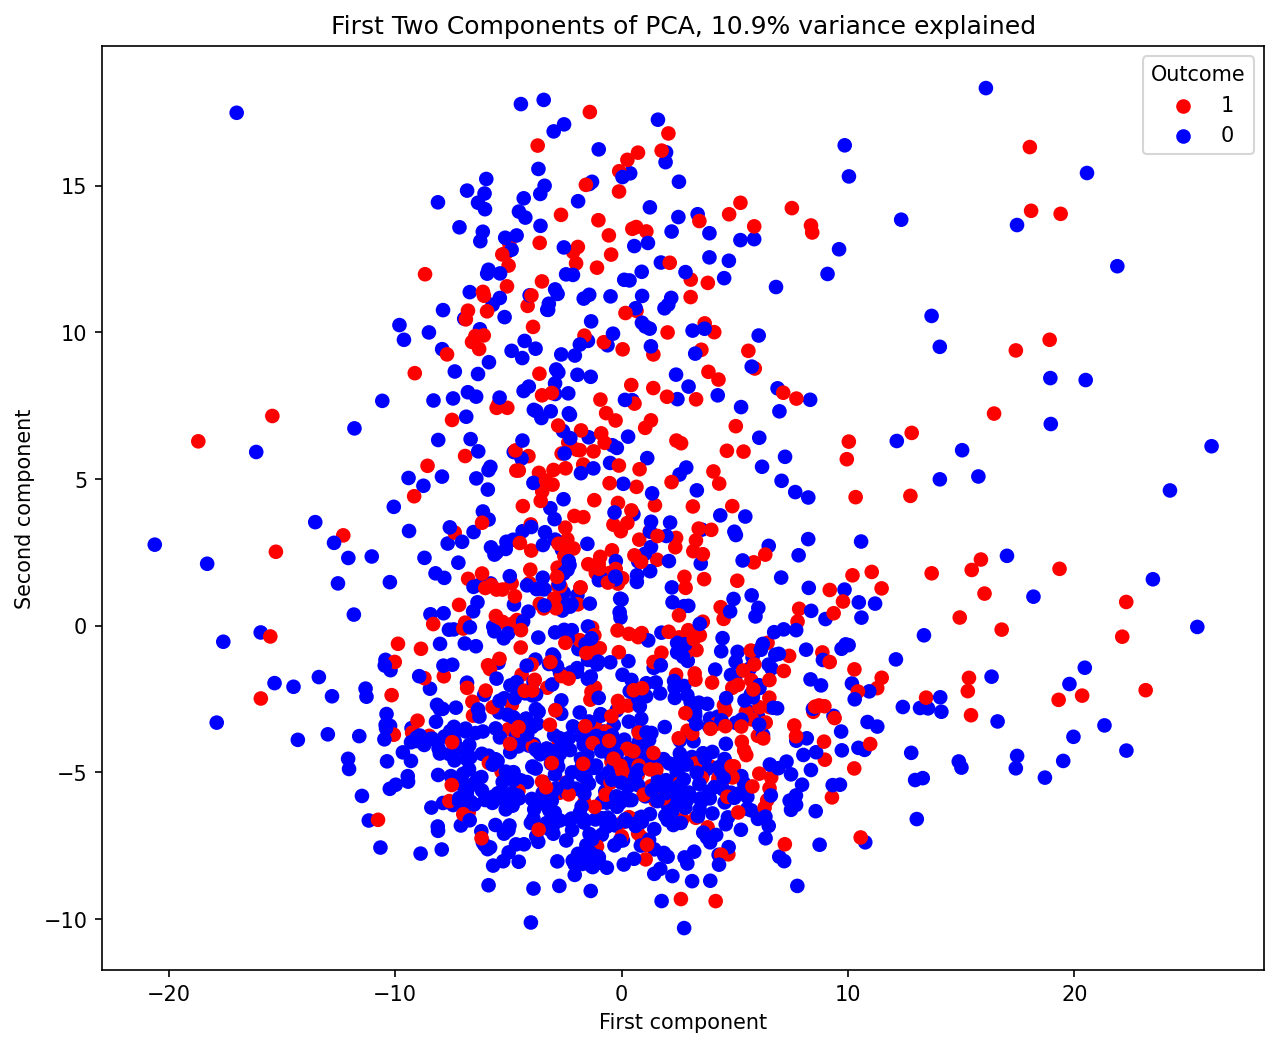

In [26]:
# Create a dictionary to map outcome values to colors
color_dict = {1: 'red', 0: 'blue'}

# Create a list of colors for each data point based on the outcome column from the training set
colors = [color_dict[val] for val in y_train]

# Get the coordinates of the first two principal components
x = train_pca190_trans[:, 0]
y = train_pca190_trans[:, 1]

# Calculate the cumulative explained variance
pc_var = 100 * pca190.explained_variance_ratio_.cumsum()[1]

plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y, c=colors)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'First Two Components of PCA, {pc_var:.1f}% variance explained')

# Add legend
handles = [plt.scatter([], [], c=color_dict[val], label=str(val)) for val in color_dict.keys()]
plt.legend(handles=handles, title='Outcome')

plt.show();



## 3.6 Initial model: Logistic Regression  <a id='3.6_initial_model'></a>

### 3.6.1 Logistic Regression  <a id='3.6.1_lr'></a>
(a) train/test split (b) create an object of the class associated with the algorithm to be used--in this case LogisticRegression (c) build an actual model using the "fit" method from the class (applied to the training set) (d) predict with the built model using the "predict" method from the class (training set and test set) (e) compute performance metrics (in this case, accuracy) for the training and test predictions

In [27]:
# first rename things so that it's easier: 
X_train_25 = train_pca25_trans
X_train_190 = train_pca190_trans
X_train_360 = train_pca360_trans
X_train_full = X_train

X_test_25 = test_pca25_trans
X_test_190 = test_pca190_trans
X_test_360 = test_pca360_trans
X_test_full = X_test


In [28]:
# look at our split data: 

print('25 Training split (PCA n_components = 25) has ', X_train_25.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(y_train))+ ')\n')


print('190 Training split (PCA n_components = 190) has ', X_train_190.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(y_train))+ ')\n')

print('360 Training split  PCA n_components = 360) has ', X_train_360.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(y_train))+ ')\n')


print('Full Training split( NO PCA)) has ', X_train.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(y_train)) + ')\n')

print('25 Test split (PCA n_components = 25) has ', X_test_25.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(y_test)) + ')\n')

print('190 Test split (PCA n_components = 190) has ', X_test_190.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(y_test)) + ')\n')


print('360 Test split (PCA n_components = 360) has ', X_test_360.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(y_test)) + ')\n')


print('Full Test split (NO PCA) has ', X_test.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(y_test)) + ')')

25 Training split (PCA n_components = 25) has  1427  rows
 and the corresponding labels have an equal number of values. (1427)

190 Training split (PCA n_components = 190) has  1427  rows
 and the corresponding labels have an equal number of values. (1427)

360 Training split  PCA n_components = 360) has  1427  rows
 and the corresponding labels have an equal number of values. (1427)

Full Training split( NO PCA)) has  1427  rows
 and the corresponding labels have an equal number of values. (1427)

25 Test split (PCA n_components = 25) has  476  rows
 and the corresponding labels have an equal number of values. (476)

190 Test split (PCA n_components = 190) has  476  rows
 and the corresponding labels have an equal number of values. (476)

360 Test split (PCA n_components = 360) has  476  rows
 and the corresponding labels have an equal number of values. (476)

Full Test split (NO PCA) has  476  rows
 and the corresponding labels have an equal number of values. (476)


In [29]:
#define function to plot class ratios between the two splits of data

def plot_y_ratios(y_train, y_test):
    fig, ax = plt.subplots(2, sharex=True)
    
    # Calculate class counts and ratios for the train set
    train_counts = y_train.value_counts()
    train_ratios = train_counts / len(y_train)
    
    # Plot the train set class ratios
    ax[0].bar(x=[0, 1], height=[train_ratios[0], train_ratios[1]])
    ax[0].set_ylabel('train', fontsize=8)
    ax[0].set_ylim(0, 1)
    
    # Calculate class counts and ratios for the test set
    test_counts = y_test.value_counts()
    test_ratios = test_counts / len(y_test)
    
    # Plot the test set class ratios
    ax[1].bar(x=[0, 1], height=[test_ratios[0], test_ratios[1]])
    ax[1].set_ylabel('test', fontsize=8)
    ax[1].set_ylim(0, 1)
    ax[1].set_xticks([0, 1])
    
    # Set the x-axis label and plot title
    ax[1].set_xlabel('Outcome\n(0 = Did not die of disease)', fontsize=8)
    ax[0].set_title('% Death from Breast Cancer (where 1 means died of disease):\n' +
                    f'train: {train_ratios[1]*100:.1f}%\ntest: {test_ratios[1]*100:.1f}%',
                    fontsize=10)
    
    plt.show()


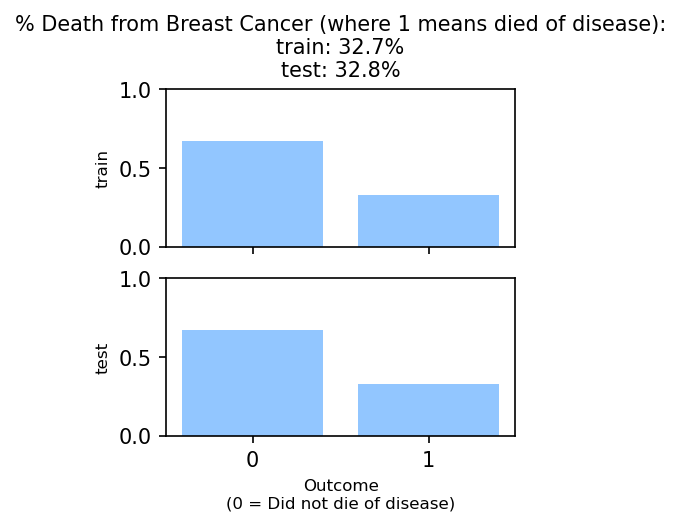

In [30]:
# compare class ratios for training and test sets. 
plot_y_ratios(y_train,y_test)

This is really close! I'm happy with this. 

In [31]:
# Construct a LogisticRegrssion object
clf25 = LogisticRegression(solver = 'newton-cg', max_iter = 500)
clf190 = LogisticRegression(solver = 'newton-cg', max_iter = 500)
clf360 = LogisticRegression(solver = 'newton-cg', max_iter = 500)
clf_full = LogisticRegression(solver = 'newton-cg', max_iter = 500) 

In [32]:
# build a model for PCA25

clf25.fit(X_train_25, y_train)

LogisticRegression(max_iter=500, solver='newton-cg')

In [33]:
# build a model for PCA190

clf190.fit(X_train_190,y_train)

LogisticRegression(max_iter=500, solver='newton-cg')

In [34]:
# build a model for PCA360
clf360.fit(X_train_360,y_train)

LogisticRegression(max_iter=500, solver='newton-cg')

In [35]:
# build a model for clf_full
clf_full.fit(X_train,y_train)

LogisticRegression(max_iter=500, solver='newton-cg')

In [36]:
# predict for n_components = 25

y_predict_test_25 = clf25.predict(X_test_25)
y_predict_training_25 = clf25.predict(X_train_25)

# predict for n_components = 190

y_predict_test_190 = clf190.predict(X_test_190)
y_predict_training_190 = clf190.predict(X_train_190)


# predict for n_components = 360

y_predict_test_360 = clf360.predict(X_test_360)
y_predict_training_360 = clf360.predict(X_train_360)

# predict for full set with all features

y_predict_test_full = clf_full.predict(X_test_full)
y_predict_training_full = clf_full.predict(X_train_full)

### 3.6.2 Performance Metrics  <a id='3.6.2_metrics'></a>

Compute performance metrics and test predictions. First I'll look at accuracy, then confusion matrix, then classification report. 

In [37]:
# Test set accuracy scores
print("[Test] Accuracy score (y_predict_test_25, y_test):",
      f'{accuracy_score(y_test,y_predict_test_25):.2f}')

print("[Test] Accuracy score (y_predict_test_190, y_test):",
      f'{accuracy_score(y_test,y_predict_test_190):.2f}')

print("[Test] Accuracy score (y_predict_test_360, y_test):",
      f'{accuracy_score(y_test,y_predict_test_360):.2f}')


print("[Test] Accuracy score (y_predict_test_full, y_test):",
      f'{accuracy_score(y_test,y_predict_test_full):.2f}')


[Test] Accuracy score (y_predict_test_25, y_test): 0.68
[Test] Accuracy score (y_predict_test_190, y_test): 0.70
[Test] Accuracy score (y_predict_test_360, y_test): 0.66
[Test] Accuracy score (y_predict_test_full, y_test): 0.63


In [38]:
# Training set accuracy scores

print("[Training] Accuracy score for 25 components: (y_train, y_predict_training_25)", 
      f'{accuracy_score(y_train, y_predict_training_25):.2f}')

print("[Training] Accuracy score for 190 components: (y_train, y_predict_training_190)", 
      f'{accuracy_score(y_train, y_predict_training_190):.2f}')

print("[Training] Accuracy score for 360 components: (y_train, y_predict_training_360)", 
      f'{accuracy_score(y_train, y_predict_training_360):.2f}')


print("[Training] Accuracy score for full features : (y_train, y_predict_training_full)", 
      f'{accuracy_score(y_train, y_predict_training_full):.2f}')

[Training] Accuracy score for 25 components: (y_train, y_predict_training_25) 0.70
[Training] Accuracy score for 190 components: (y_train, y_predict_training_190) 0.78
[Training] Accuracy score for 360 components: (y_train, y_predict_training_360) 0.82
[Training] Accuracy score for full features : (y_train, y_predict_training_full) 0.98


There is clearly overfitting going on. It appears to be overfitting more with 190 components. Note that we shouldn't really trust the accuracy score by itself, especially because we have imbalanced classes.

To summarize:</br>

<b>Accuracy Scores for 25 components</b>:

Test: 0.67 </br>
Train: 0.70 </br>

<b>Accuracy Scores for 190 components</b>:

Test: 0.78 </br>
Train: 0.97 </br>

<b> Accuracy Scores for ~360 components </b>

Test: 0.75 </br>
Train: 0.88

<b> Accuracy Scores for data with no PCA </b>

Test: 0.76   </br>
Train: 1.00

### Confusion Matrix

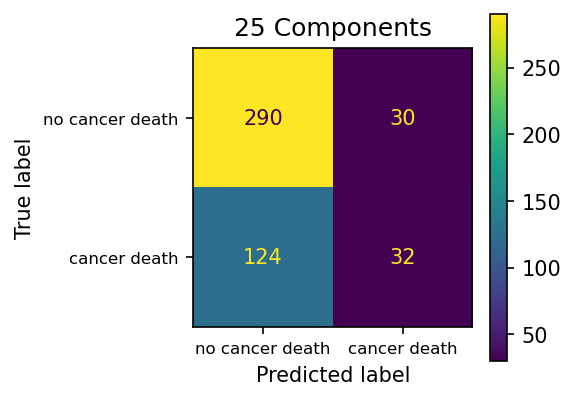

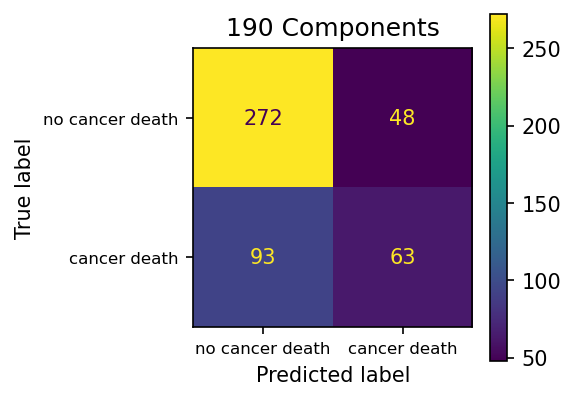

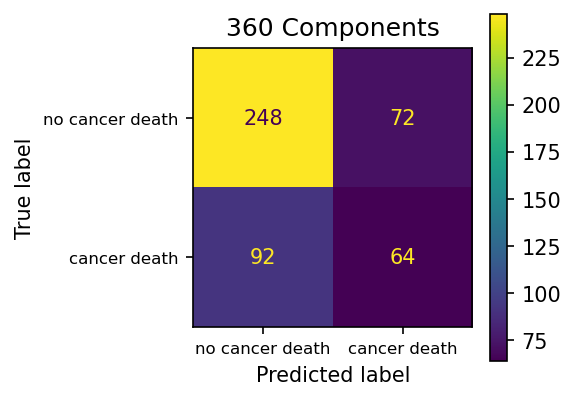

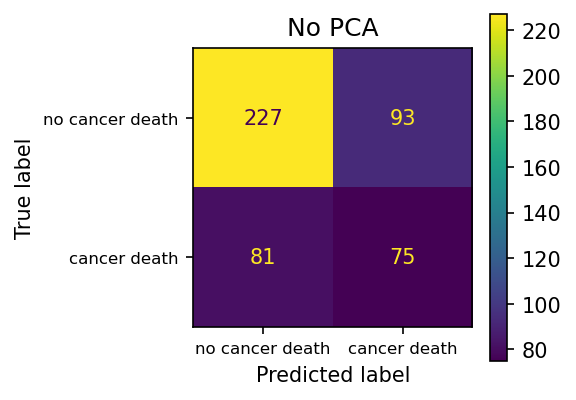

In [39]:
# 25 components:

cm = confusion_matrix(y_test, y_predict_test_25, labels = clf25.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no cancer death', 'cancer death'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
ax.set_yticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
plt.title('25 Components')
display_cm.plot(ax = ax)
plt.show();



# 190 components:

cm = confusion_matrix(y_test, y_predict_test_190, labels = clf190.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no cancer death', 'cancer death'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
ax.set_yticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
plt.title('190 Components')
display_cm.plot(ax = ax)
plt.show();

# 360 components:

cm = confusion_matrix(y_test, y_predict_test_360, labels = clf360.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no cancer death', 'cancer death'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
ax.set_yticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
plt.title('360 Components')
display_cm.plot(ax = ax)
plt.show();

# full data set (no PCA)
cm = confusion_matrix(y_test, y_predict_test_full, labels = clf_full.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no cancer death', 'cancer death'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
ax.set_yticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
plt.title('No PCA')
display_cm.plot(ax = ax)
plt.show();

From these confusion matrixes it looks like the set with no PCA is the best at correctly labeling cancer death, followed by 360 components, 190 components and 25 components. 190 components was the best at identifying 'no cancer death'. However, they were all quite close, except for the 25 components

<b> Classification report for 25 components:</b>

In [40]:
# Training:

print(classification_report(y_train, y_predict_training_25))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       961
           1       0.59      0.29      0.39       466

    accuracy                           0.70      1427
   macro avg       0.66      0.59      0.59      1427
weighted avg       0.68      0.70      0.67      1427



In [41]:
# Testing:

print(classification_report(y_test, y_predict_test_25))

              precision    recall  f1-score   support

           0       0.70      0.91      0.79       320
           1       0.52      0.21      0.29       156

    accuracy                           0.68       476
   macro avg       0.61      0.56      0.54       476
weighted avg       0.64      0.68      0.63       476



<b>Classification report for 190 components:</b>

In [42]:
# Training:

print(classification_report(y_train, y_predict_training_190))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       961
           1       0.71      0.55      0.62       466

    accuracy                           0.78      1427
   macro avg       0.76      0.72      0.73      1427
weighted avg       0.77      0.78      0.77      1427



In [43]:
# Testing:

print(classification_report(y_test, y_predict_test_190))

              precision    recall  f1-score   support

           0       0.75      0.85      0.79       320
           1       0.57      0.40      0.47       156

    accuracy                           0.70       476
   macro avg       0.66      0.63      0.63       476
weighted avg       0.69      0.70      0.69       476



<b>Classification report for ~360 components:</b>

In [44]:
# Training:

print(classification_report(y_train, y_predict_training_360))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       961
           1       0.76      0.68      0.72       466

    accuracy                           0.82      1427
   macro avg       0.81      0.79      0.79      1427
weighted avg       0.82      0.82      0.82      1427



In [45]:
# Testing:

print(classification_report(y_test, y_predict_test_360))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75       320
           1       0.47      0.41      0.44       156

    accuracy                           0.66       476
   macro avg       0.60      0.59      0.59       476
weighted avg       0.64      0.66      0.65       476



<b> Classification report for no PCA </b>

In [46]:
# Training:

print(classification_report(y_train, y_predict_training_full))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       961
           1       0.98      0.96      0.97       466

    accuracy                           0.98      1427
   macro avg       0.98      0.97      0.98      1427
weighted avg       0.98      0.98      0.98      1427



In [47]:
# Testing:

print(classification_report(y_test, y_predict_test_full))

              precision    recall  f1-score   support

           0       0.74      0.71      0.72       320
           1       0.45      0.48      0.46       156

    accuracy                           0.63       476
   macro avg       0.59      0.60      0.59       476
weighted avg       0.64      0.63      0.64       476



Notes: These all had similar test scores, and none of them did a good job at predicting death from cancer. 
</br>
<b>F1 scores for predicting class 1 (cancer death):</b>
* 25 components: 0.30
* 190 components: 0.46
* 360 components: 0.44
* full data set: 0.46

There is also significant overfitting happening, but less so with the 190 components. So far this is my favorite model. 

## 3.7 Exporting  <a id='3.7_export'></a>

In [49]:
''' these are the files I need to export, do so using pickle. 
X_train_25
X_train_190 
X_train_360 
X_train_full 
X_test_25
X_test_190 
X_test_360 
X_test_full 

'''
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_train_25.pkl', 'wb') as file:
    pickle.dump(X_train_25, file) 

with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_test_25.pkl', 'wb') as file:
    pickle.dump(X_test_25, file)
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_train_190.pkl', 'wb') as file:
    pickle.dump(X_train_190, file) 

with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_test_190.pkl', 'wb') as file:
    pickle.dump(X_test_190, file)
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_train_360.pkl', 'wb') as file:
    pickle.dump(X_train_360, file)
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_test_360.pkl', 'wb') as file:
    pickle.dump(X_test_360, file)
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_train_full.pkl', 'wb') as file:
    pickle.dump(X_train_full, file)
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_test_full.pkl', 'wb') as file:
    pickle.dump(X_test_full, file)
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)   

with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)   
    
# export to a parquet so we can save data type - remove index=False
num_data.to_parquet(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\num_data2.parquet', index=True)

## 3.8 Summary & Next Steps <a id='3.8_summary'></a>

In this notebook I did a test/train split on my numeric dataset, scaled it, and then performed PCA. I did PCA for 25 and 190 components, so as to prevent issues from being 'wide and short', and also for 360 components, which accounts for 90% of the variance in my dataset. I performed logistic regression on all 4 sets, and found that their performance metrics were overall similar. The F1 scores for accurately predicting death from cancer (1) for my test sets were all between 0.30-46, though I noted that there appears to be less overfitting with the set with 190 components, and the set with only 25 components performed the worst.

Next, I will do hyperparameter tuning and regularization to see if I can make an improved logistic regression model, and determine if F1 really is the best metric to judge our models on. I will also try other models on our data sets, including XG Boost, Random Forest Classifier, and LGBM Classifier. 

The next notebook is titled '4. Capstone_2_Modeling'